# Challenge files

In [1]:
import signal
import pandas as pd


def set_alarm_clock(timeout):
    """
    Raise TimeoutError if time > timeout.
    Remember to deactivate alarm if not required - use timeout=-1
    :param timeout: in seconds.
    :return:
    """
    def signal_handler(signum, frame):
        raise TimeoutError("Timeout")

    signal.signal(signal.SIGALRM, signal_handler)
    if timeout > 0:
        signal.alarm(timeout)
    elif timeout<0:
        signal.alarm(10**10)

def load_data_json(data_path):
    df = pd.read_json(data_path)
    xs = []
    ys = []
    for col in df.columns:
        if '_in' in col:
            xs.append(col)
        if '_out' in col:
            ys.append(col)

    xs = [df[['time',col]].to_numpy(dtype=float) for col in xs]
    ys = [df[col].to_numpy(dtype=float).reshape(-1,1) for col in ys]
    return xs, ys

def load_data_csv(data_path,name_time="Time",
                            name_input="input",
                            names_outputs = ["output"+str(k) for k in range(1,6)],
                            Ndecim = 1
                 ):
    
    df = pd.read_csv(data_path,sep=',',index_col=False)
    
    return df[name_time].to_numpy()[::Ndecim],df[name_input].to_numpy()[::Ndecim],df[names_outputs].to_numpy()[::Ndecim]

In [2]:
# DO NOT MODIFY
# Given As-Is to candidates - do not modify
from typing import List

import numpy as np

##################################################
# This is the ModelApi virtual class definition
# It is mandatory that your model's interface (as in my_model1.py)  
# inheritates from this class
#
# There is no need for the candidate to modify this
##################################################
## Authors: Orion Talmi,François Caire
## Maintainer: François Caire
## Email: francois.caire at skf.com
##################################################


class ModelApi:
    """Interface for Magnetic Bearing Model. All the following methods,
    must be implemented by your model
    """

    @classmethod
    def create_model(cls, gpu_available:bool=False):
        """

        :param gpu_available: whether a gpu device is available.
        :return: an instance of your model. Use "return cls(*your_args, **your_kwargs)" to call your constructor.
        Note: create_model is expected to take no more than 30 seconds
        """
        raise NotImplementedError('model create_model() was not implemented')

    @property
    def description(self):
        """
        :return: a dictionary with the following properties
        """

        team_name = 'team_name'  #NO SPACE ALLOWED
        email = 'your_email@gmail.com'
        model_title = 'Model title - e.g. My Favorite Model'
        affiliation = 'Company/Instituition'
        description = 'description of the model and architecture'
        technology_stack = 'technology stack you are using, e.g. sklearn, pytorch'
        other_remarks = "put here anything else you'd like us to know"

        return dict(team_name=team_name,
                    email=email,
                    model_title=model_title,
                    description=description,
                    technology_stack=technology_stack,
                    other_remarks=other_remarks,
                    affiliation=affiliation)

    @classmethod
    def get_sagemaker_estimator_class(self):
        """
        return the class with which to initiate an instance on sagemaker:
        e.g. SKLearn, PyTorch, TensorFlow, etc.
        by default - use SKLearn image.

        """

        # Implementation examplea:
        """
        from sagemaker.sklearn import SKLearn
        return SKLearn
        """

        # or

        """
        from sagemaker.pytorch import PyTorch
        return PyTorch
        """

        raise NotImplementedError('model get_sagemaker_estimator_class() was not implemented')

    def fit(self, xs: List[np.ndarray], ys: List[np.ndarray], timeout=36000):
        """ train on several (x, y) examples
        :param xs: input data given as a list containing one dimensionnal array corresponding to input samples
        :param ys: output data given as a list of one dimensionnal arrays corresponding to output samples
        :param timeout: maximal time (on the hosting machine) allowed for this operation (in seconds).
        """

        raise NotImplementedError('model fit() was not implemented')

    def predict_timeseries(self, x: np.ndarray) -> np.ndarray:
        """ produce a prediction: x -> y where x is the entire time series from the beginning

        :param x: 1 input series given as a 2D ndarray with rows representing samples, and columns representing features.
        :return:  corresponding predictions as 2D np.ndarray

        Note: calling predict_series may change model's state.
        Note: self.predict_series(x) should return the same results as [self.predict_one_timepoint(xi) for xi in x] up to 5 digits precision.
        Note: predict_timeseries is expected to take no more than 1 second per sample
        """

        raise NotImplementedError('model predict() was not implemented')


    def save(self, model_dir:str):
        """ save the model to a file
        :param path: a path to the file which will store the model

        Note: save is expected to take no more than 10 minutes
        """

        raise NotImplementedError('model predict() was not implemented')

    @classmethod
    def load(cls, model_dir:str):#->ModelApi
        """ load a pretrained model from a file
        :param path: path to the file of the model.
        :return: an instance of this class initialized with loaded model.

        Note: save is expected to take no more than 10 minutes
        """

        raise NotImplementedError('model load() was not implemented')

In [3]:
import unittest
import sys
from pprint import pprint
from importlib import import_module

import numpy
import numpy as np

    
##################################################
# This script defines and launches unittests on a model definition file
# It is provided so the candidates can test at any time the validity of the model definition 
# he intends to submit.
# Indeed, the evaluation of the submission necessitates the metrics computation 
# on sagemaker instance which is done by launching the calc_metrics* scripts
#
# See example notebook for an example of how to use this script
##################################################
## Authors: Orion Talmi, François Caire
## Maintainer: François Caire
## Email: francois.caire at skf.com
##################################################
try:
    from utility_functions import load_data_csv
except:pass
try:
    from utilities.utility_functions import load_data_csv
except:pass
try:
    from sources.utilities.utility_functions import load_data_csv
except:pass

class TestSubmission(unittest.TestCase):

    def test_mymodel(self, MyModel):
        with self.subTest(name='create test data'):
            data = '/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_example/input1.csv'
            _,self.xs,self.ys = load_data_csv(data)

        with self.subTest(name='create model'):
            model = MyModel.create_model()

        with self.subTest(name='fit 1'):
            x_train,y_train = [self.xs[:50]],[self.ys[:50,k] for k in range(5)]
            model.fit(x_train,y_train)
            y_pred = model.predict_timeseries(self.xs[:50])
            self.assertTrue(isinstance(y_pred,np.ndarray))
            self.assertEqual(len(y_pred),50)

        with self.subTest(name='print description'):
            description = model.description
            print("Model Description : ")
            pprint(description)
            self.assertTrue(isinstance(description, dict))

        with self.subTest(name='save/load 1'):
            model.save('./tmp/')
            model2 = model.load('./tmp/')
            self.assertEqual(model.description, model2.description)

        with self.subTest(name='predict all'):
            y2 = model2.predict_timeseries(self.xs[:50])
            self.assertTrue(isinstance(y2, np.ndarray))
            self.assertEqual(len(y2[0,:]), 5)
            self.assertEqual(y2[:,0].shape, self.xs[:50].shape)
            self.assertEqual(y2[:,0].shape, self.ys[:50,0].shape)

        with self.subTest(name='compare prediction after predictions'):
            y1 = model.predict_timeseries(self.xs[-50:-1])
            y2 = model2.predict_timeseries(self.xs[-50:-1])
            self.assertTrue(np.all(y1 == y2))

# My implementation

In [4]:
# Libraries
from scipy import signal, optimize, fftpack
import matplotlib.pyplot as plt
import numpy as np
import os
import json

In [5]:
# Libraries
from scipy import signal, optimize, fftpack
import numpy as np

class RC2Model(ModelApi):

    def __init__(self, init_params=(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5)):
        # Save kwargs
        self.model_kwargs = {
            'init_params' : init_params,
        }
        # Initial parameters for the RC filter
        self.init_params = np.array(init_params)

    def filter_low_pass_order2(self, f, a):
      z = 2.0 * np.pi * f * 1j
      return ((a[0] + a[1] * z) / (a[2] + a[3] * z + a[4] * (z*z)))

    def apply_filter(self, X, filter_args, f=None, a=None):
      if f is None:
        f = fftpack.fftfreq(X.shape[0])
      if a is None:
        a = fftpack.fft(X)
      a_out = a * self.filter_low_pass_order2(f, filter_args)
      return fftpack.ifft(a_out)
    
    def pred(self, X, params, f=None, a=None):
      return params[5] * self.apply_filter(X, params[:5], f=f, a=a).real + params[6]

    def fit(self, xs: List[np.ndarray], ys: List[List[np.ndarray]], timeout=36000):
        self.num_outputs = len(ys)
        self.best_params = np.empty((self.num_outputs, self.init_params.shape[0]))
        for j in range(self.num_outputs):
          # Run the optimizer on MSE
          f = fftpack.fftfreq(xs[0].shape[0])
          a = fftpack.fft(xs[0])
          ret_rc = optimize.minimize(lambda params : np.mean(np.square(self.pred(xs[0], params, f=f, a=a) - ys[j])), self.init_params, method='Powell')
          # Save the best parameters
          self.best_params[j] = ret_rc.x

    @classmethod
    def get_sagemaker_estimator_class(self):
        from sagemaker.sklearn import SKLearn
        return SKLearn

    def predict_timeseries(self, x: np.ndarray) -> np.ndarray:
        return np.vstack([self.pred(x, self.best_params[j]) for j in range(self.num_outputs)]).T

    def save(self, model_dir: str):
        os.makedirs(model_dir, exist_ok=True)
        path = os.path.join(model_dir, 'model_kwargs.json')
        with open(path, 'w') as f:
            json.dump(self.model_kwargs, f)

        path = os.path.join(model_dir, 'model.npy')
        with open(path, 'wb') as f:
          np.save(f, self.best_params)
        
    @classmethod
    def load(cls, model_dir: str):
        path = os.path.join(model_dir, 'model_kwargs.json')
        with open(path, 'r') as f:
            model_kwargs = json.load(f)
            
        my_model = cls(**model_kwargs)

        path = os.path.join(model_dir, 'model.npy')
        with open(path, 'rb') as f:
            my_model.best_params = np.load(f)
            my_model.num_outputs = my_model.best_params.shape[0]

        return my_model

    @classmethod
    def create_model(cls, gpu_available: bool = False, **kwargs):
        return cls(**kwargs)

    @property
    def description(self):
        team_name = 'SimpleModels'
        email = 'louis.grenioux@polytechnique.edu'
        model_name = 'RC2'
        affiliation = 'Télécom SudParis'
        description = 'Order 2 low pass filter'
        technology_stack = 'scipy'
        other_remarks = ''

        return dict(team_name=team_name,
                    email=email,
                    model_name=model_name,
                    description=description,
                    technology_stack=technology_stack,
                    other_remarks=other_remarks,
                    affiliation=affiliation)

# Do various tests

In [6]:
TestSubmission().test_mymodel(RC2Model)

Model Description : 
{'affiliation': 'Télécom SudParis',
 'description': 'Order 2 low pass filter',
 'email': 'louis.grenioux@polytechnique.edu',
 'model_name': 'RC2',
 'other_remarks': '',
 'team_name': 'SimpleModels',
 'technology_stack': 'scipy'}


In [7]:
import time
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def compute_metrics(filename, skip_plot=False, example_dataset=False):
  # Build the model
  model = RC2Model()

  # Load the data
  # Load the data
  if example_dataset:
    _ , x, y = load_data_csv(data_path=filename, name_input="input", names_outputs = ["output"+str(k) for k in range(1,6)])
  else:
    _ , x, y = load_data_csv(data_path=filename, name_input="Input", names_outputs = ["Output"+str(k) for k in range(1,6)])

  # Build train and test
  # time_limit = int(0.50 * x.shape[0])
  # x_train, x_test = x[:time_limit], x[time_limit:]
  # y_train, y_test = [], []
  # for j in range(len(y)):
  #   y_train.append(y[j][:time_limit])
  #   y_test.append(y[j][time_limit:])
  # -> Test on train
  x_train, y_train, x_test, y_test = x,y,x,y

  # Train
  ts = time.time()
  model.fit(xs=[x_train], ys=[y_train[:,k] for k in range(5)])
  metric_train_time = time.time() - ts
  print("Best params :")
  print(model.best_params)

  # Inference Time computation :
  ts = time.time()
  y_pred = model.predict_timeseries(x_test)
  inf_time =(time.time() - ts)

  metric_mean_inference_time  = inf_time/len(x_test)

  # Normalized Error Computation : 
  y_pred = model.predict_timeseries(x_test)
  max_ytest_value = np.zeros( (5,1) )
  for k in range(5) :
    max_ytest_value[k] = np.max(np.abs(y_test[:,k]))
    if not skip_plot:
      plt.figure(figsize=(20,5))
      plt.plot(range(x_test.shape[0]), x_test, label="Input")
      plt.plot(range(y_test.shape[0]), y_test[:,k], label="Target")
      plt.plot(range(y_pred.shape[0]), y_pred[:,k], label="Prediction")
      plt.legend()
      plt.show()

  metric_normalized_mse = np.zeros( (5,) )
  for k in range(5):
    metric_normalized_mse[k] = mean_squared_error(y_true=y_test[:,k]/max_ytest_value[k],y_pred=y_pred[:,k]/max_ytest_value[k])
  weights_mse = np.array( [1,1,1,1,1] )
  metric_normalized_mse_sum = np.dot(weights_mse,metric_normalized_mse)

  aggregated_performance_indicator = metric_train_time/3600/1e3 + \
      metric_mean_inference_time + \
      metric_normalized_mse_sum  + \
      len(x_train)/1e6

  # End normalized error Computation
  metrics_info = { 
    'Training set size': len(x_train), 
    'Training time [seconds]' : metric_train_time,
    'Average inference time [seconds]' : metric_mean_inference_time,
    'Normalized MSE' : metric_normalized_mse,
    'Normalized MSE Sum' : metric_normalized_mse_sum,
    'Aggregated Metrics': aggregated_performance_indicator 
  }
  return metrics_info

Best params :
[[ 9.66262082e-01 -7.03939939e-01  4.96068907e-01  9.49959292e-01
  -1.03115851e+00  5.13647565e-01 -1.27324332e-10]
 [ 9.23644486e-01 -9.47843661e-01  4.82499013e-01  1.95454758e+00
   5.05846942e+00  5.19880855e-01  1.95487707e-10]
 [ 8.55014408e-01 -2.34865114e+00  4.98631405e-01  2.67965382e+00
   9.86299290e+00  5.75037934e-01  4.57304434e-08]
 [ 8.25336967e-01 -2.78619559e+00  5.06566061e-01  3.17487458e+00
   1.34592124e+01  6.03862644e-01  2.79473087e-07]
 [ 7.48254454e-01 -3.74665169e+00  5.19169312e-01  4.69748724e+00
   2.85488809e+01  6.81036316e-01  1.66069771e-06]]


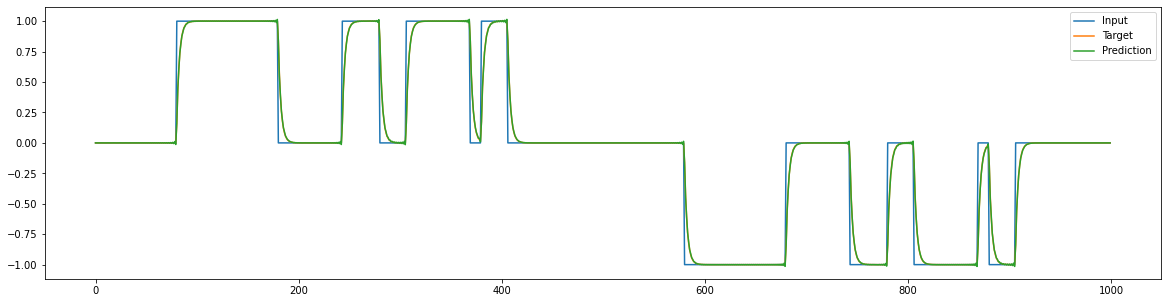

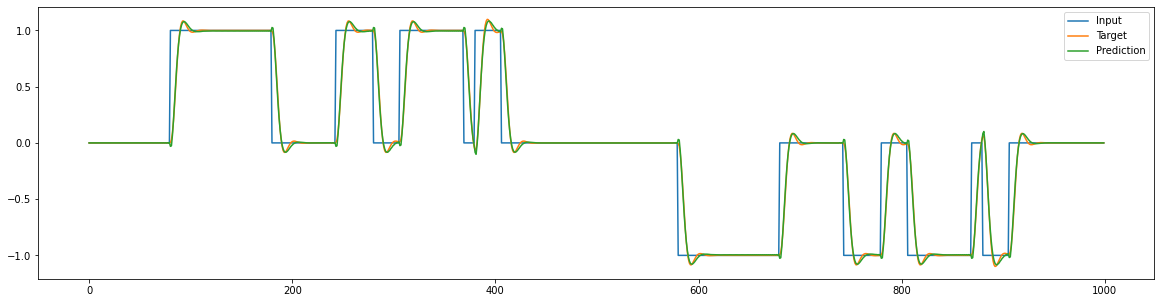

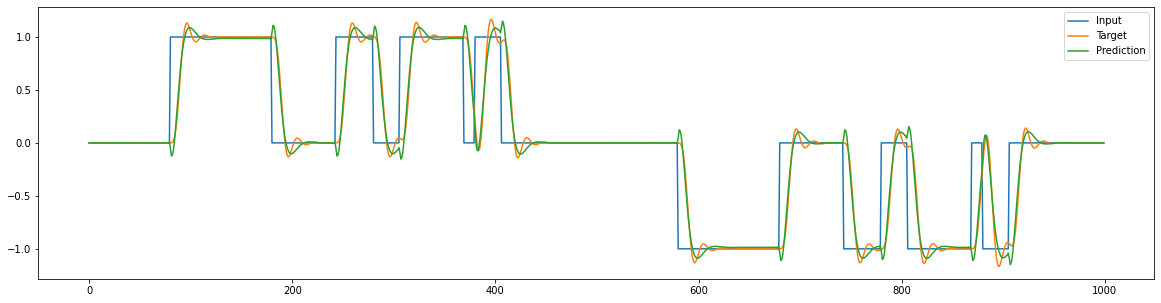

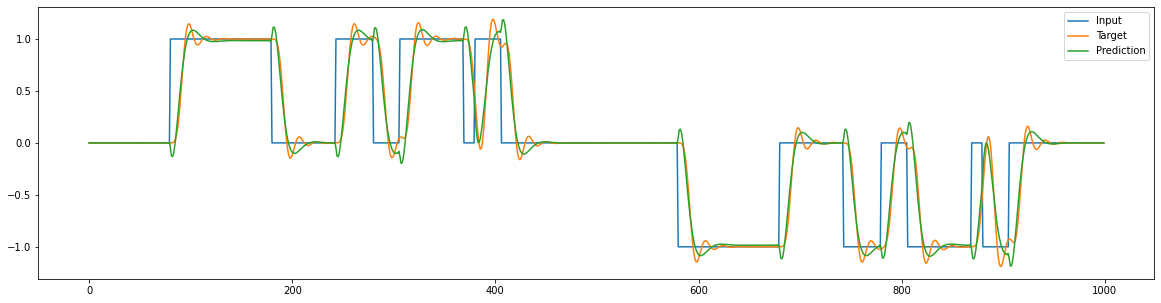

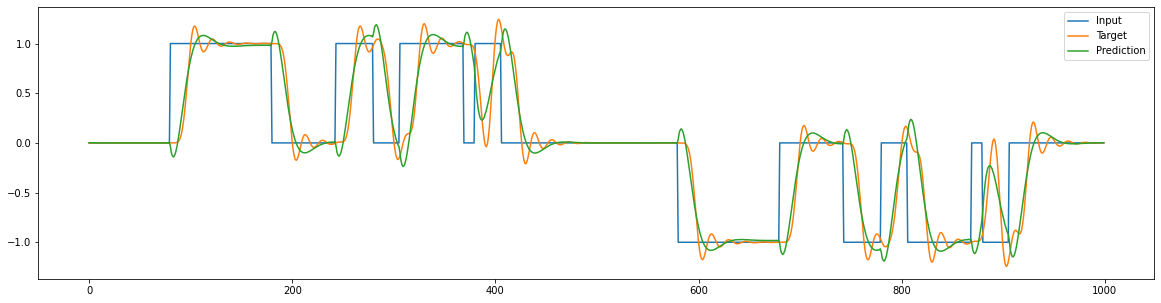

{'Aggregated Metrics': 0.015490340571155229,
 'Average inference time [seconds]': 1.9927024841308595e-06,
 'Normalized MSE': array([1.74708110e-05, 1.87776733e-04, 2.07255173e-03, 3.69080736e-03,
       8.51967180e-03]),
 'Normalized MSE Sum': 0.01448827844124709,
 'Training set size': 1000,
 'Training time [seconds]': 0.2499387264251709}
Best params :
[[ 1.01319715  1.37427961  0.49909533  1.36511967 -0.05482903  0.50060194
  -0.0175736 ]
 [ 1.02051733  7.80832005  0.48758889  5.40042669 11.13819088  0.49362368
  -0.03572061]
 [ 1.06228488  2.63670481  0.4981048   3.89685979 -0.6176361   0.50132164
  -0.07207654]
 [ 1.07893806  3.33392169  0.49806684  4.79454303 -0.81545491  0.50142834
  -0.08938542]
 [ 1.13737146  5.9924006   0.49718345  7.85089871 -1.63201924  0.50194004
  -0.15148748]]


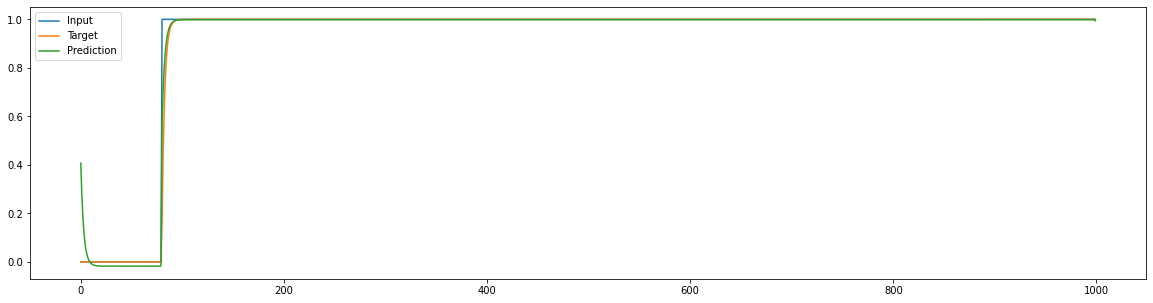

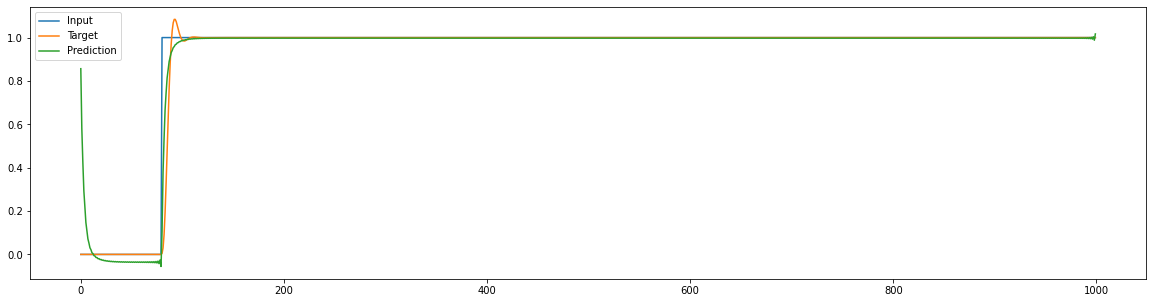

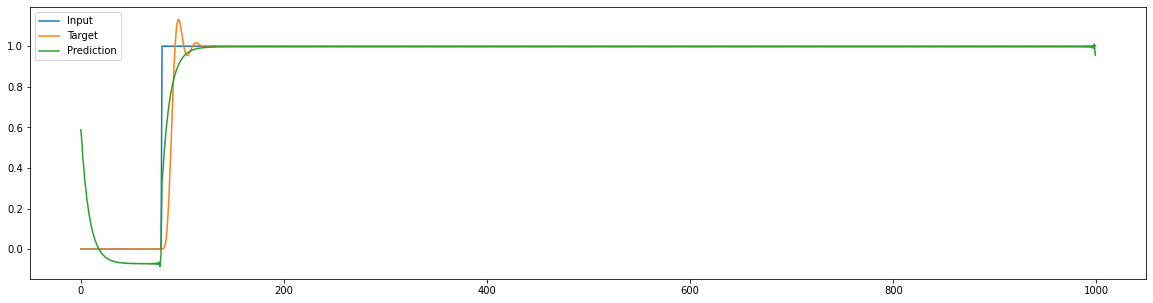

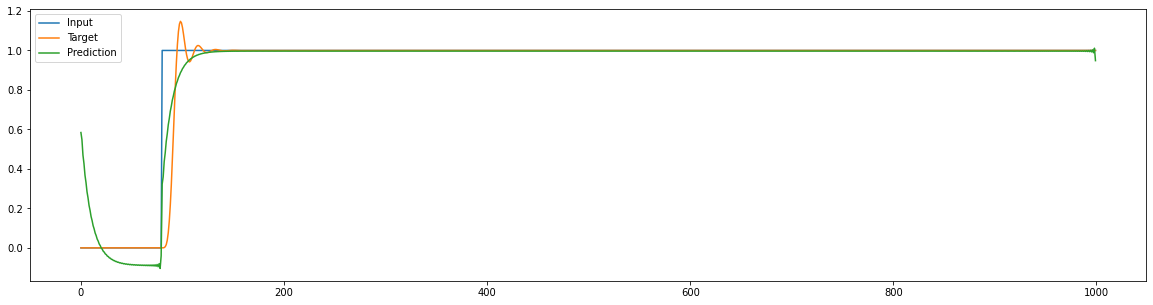

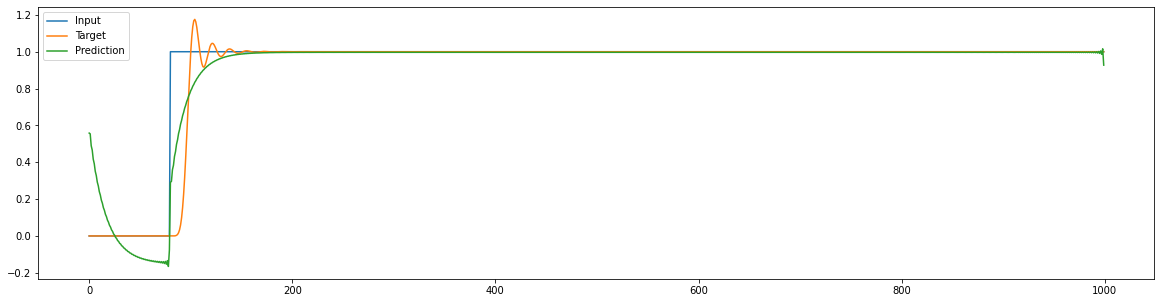

{'Aggregated Metrics': 0.015290673103769917,
 'Average inference time [seconds]': 6.40869140625e-07,
 'Normalized MSE': array([0.00063057, 0.00212132, 0.00302288, 0.00355152, 0.00496365]),
 'Normalized MSE Sum': 0.014289936841037836,
 'Training set size': 1000,
 'Training time [seconds]': 0.3434169292449951}
Best params :
[[ 9.53105846e-01 -1.40203908e+00  4.99676971e-01  5.76061490e-01
  -1.93074192e+00  5.24288365e-01 -4.67947958e-09]
 [ 9.10620103e-01 -1.16490722e+00  5.09087597e-01  2.00952717e+00
   3.88447098e+00  5.56873668e-01  3.60270303e-07]
 [ 1.18176499e+00 -3.33372768e+00  5.02072467e-01  2.81897396e+00
   7.32014834e+00  4.17738098e-01  1.54492650e-06]
 [ 7.65635628e-01 -2.73427035e+00  4.97116108e-01  3.21467260e+00
   9.87794042e+00  6.28977026e-01  2.88693947e-06]
 [ 9.61686498e-01 -6.10075262e+00  4.69766405e-01  3.92299423e+00
   1.92869130e+01  4.19838019e-01  1.29724460e-05]]


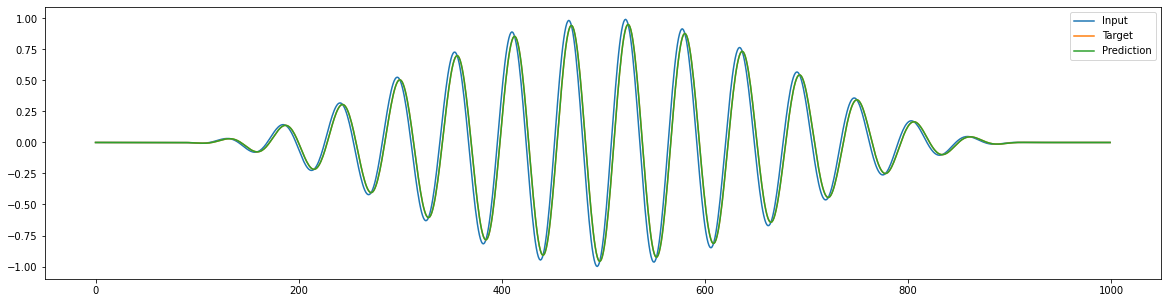

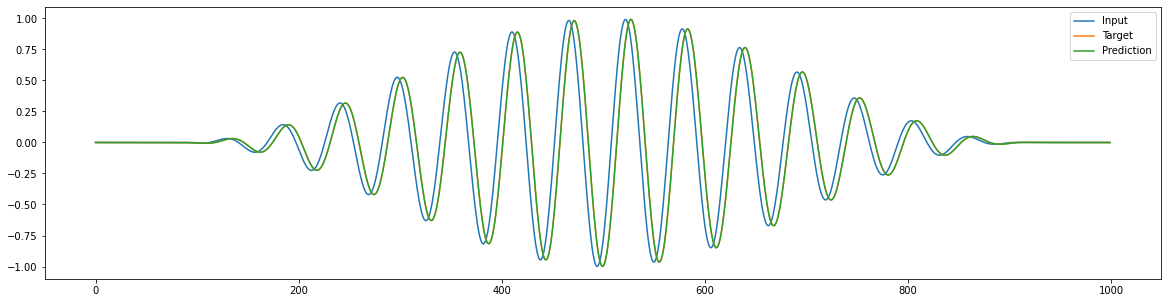

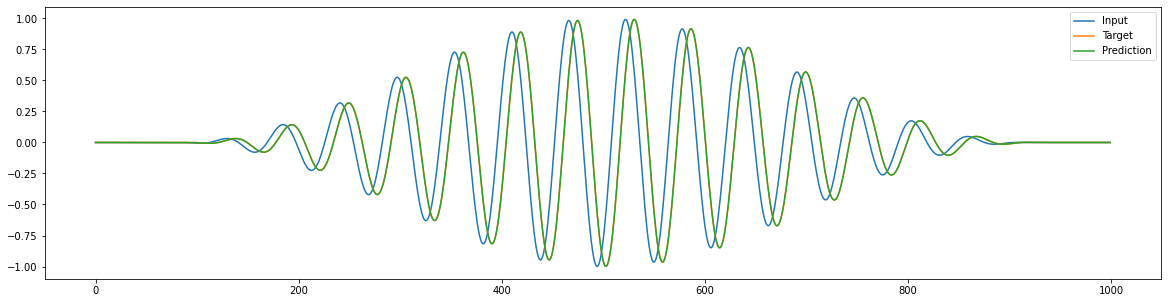

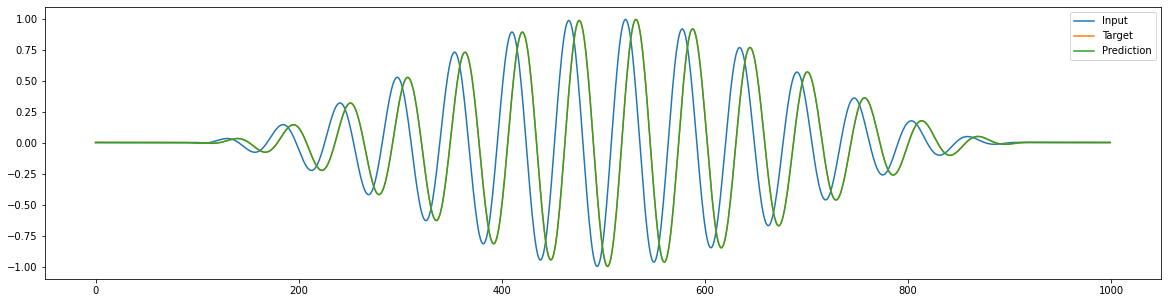

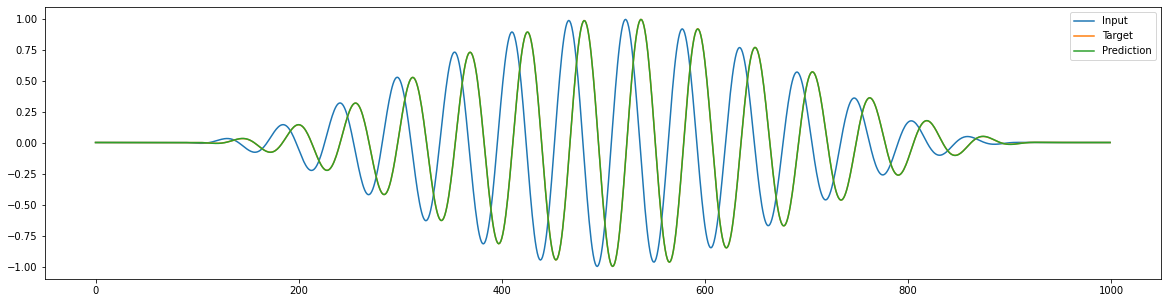

{'Aggregated Metrics': 0.0010025883611882182,
 'Average inference time [seconds]': 1.997709274291992e-06,
 'Normalized MSE': array([8.36995209e-11, 9.80450559e-10, 1.20098853e-08, 2.92982843e-08,
       3.10844889e-07]),
 'Normalized MSE Sum': 3.532172088278388e-07,
 'Training set size': 1000,
 'Training time [seconds]': 0.8547649383544922}
Best params :
[[ 9.79860906e-01 -1.16905032e+00  4.94609905e-01  7.13964750e-01
  -1.61379614e+00  5.04823966e-01  1.05050463e-05]
 [ 9.81519571e-01 -9.99630516e-01  4.97268643e-01  2.03279510e+00
   5.20668738e+00  5.05987024e-01 -1.63060376e-04]
 [ 9.64388626e-01 -2.57743450e+00  5.01336029e-01  2.75934356e+00
   9.94859756e+00  5.18041917e-01 -4.47306497e-04]
 [ 9.55945882e-01 -3.23779191e+00  5.03146936e-01  3.21108942e+00
   1.32308578e+01  5.24047516e-01 -5.61437799e-04]
 [ 9.30531368e-01 -5.01660056e+00  5.07780872e-01  4.67476140e+00
   2.69981604e+01  5.42004656e-01 -8.70591822e-04]]


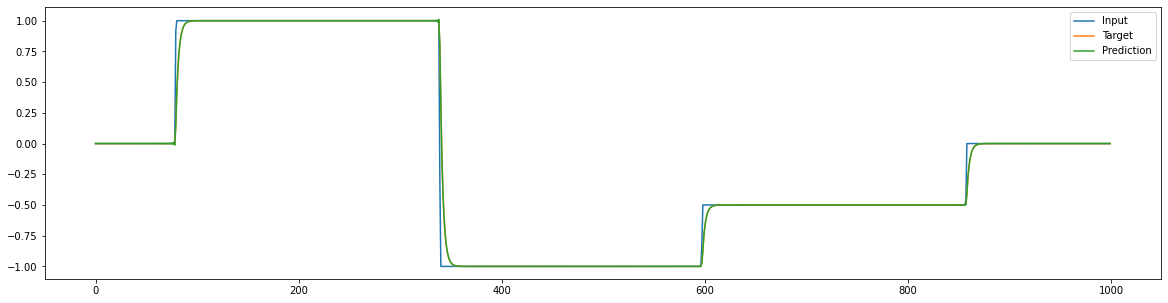

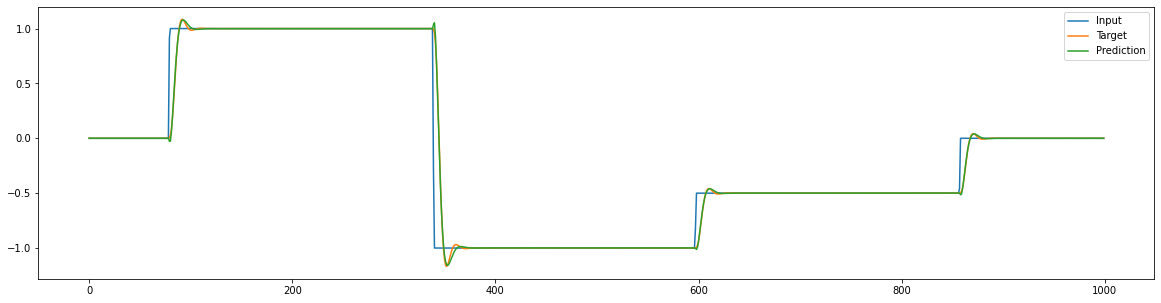

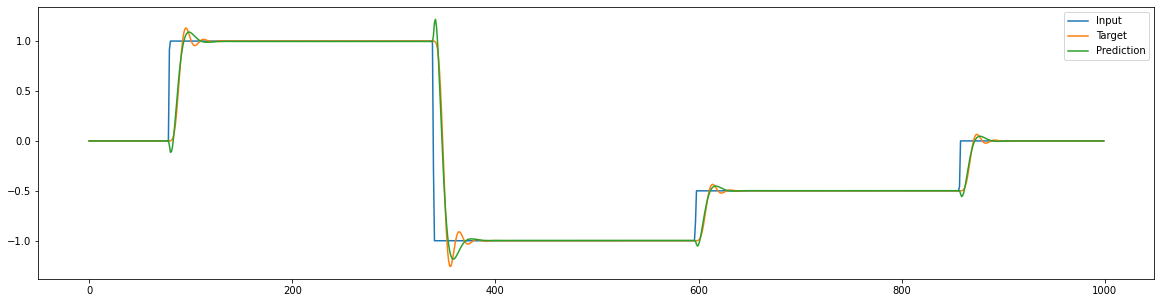

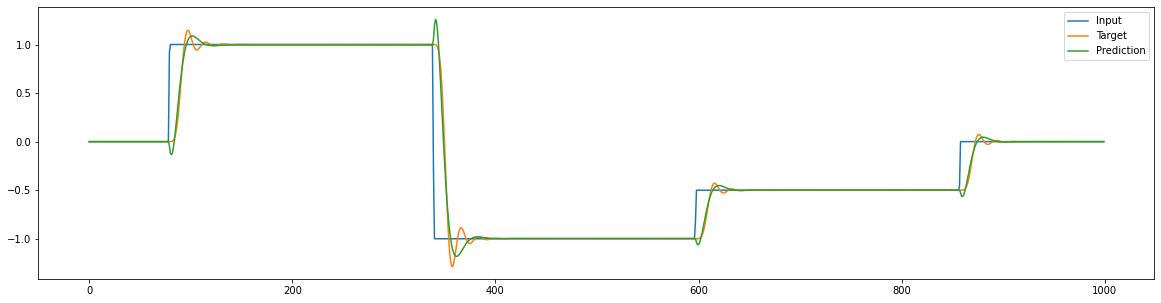

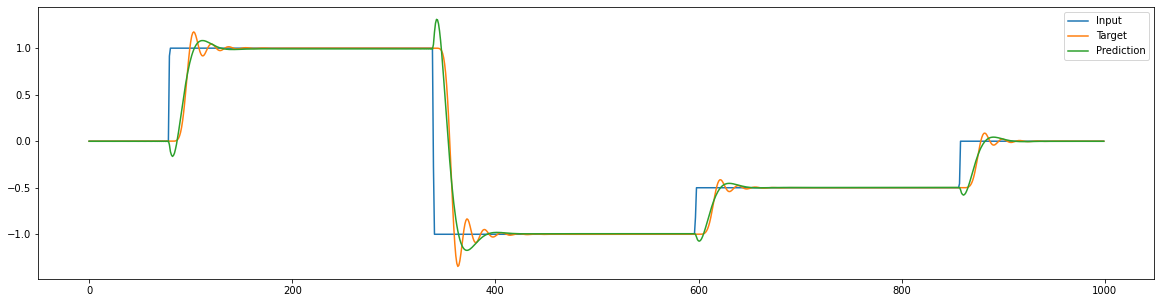

{'Aggregated Metrics': 0.00451989003844179,
 'Average inference time [seconds]': 1.5268325805664062e-06,
 'Normalized MSE': array([2.55733050e-06, 5.53109927e-05, 5.36204702e-04, 8.90066111e-04,
       2.03414000e-03]),
 'Normalized MSE Sum': 0.0035182791351654526,
 'Training set size': 1000,
 'Training time [seconds]': 0.302654504776001}
Best params :
[[ 4.68872806e-01  3.09302903e-01  2.56640109e-01  8.47042785e-01
   5.66669015e-01  5.25226966e-01  5.04439484e-04]
 [ 5.46138537e-02 -4.33349379e-02  6.00111546e-02  2.09738298e-01
   7.31255328e-01  9.89888795e-01  1.23441256e-03]
 [ 4.99118722e-02 -1.19396125e-01  1.33417096e-01  4.84166083e-01
   2.93301302e+00  2.02442411e+00  3.03631589e-03]
 [-1.70836277e-02  1.12017674e-02  6.79769782e-02 -6.41546506e+01
  -6.96847378e+01  3.47579036e+01  1.21083911e-01]
 [ 4.23649429e-02 -2.17327642e-01  4.37152155e-02  2.36832970e-01
   2.44089353e+00  7.35624627e-01  3.59825511e-03]]


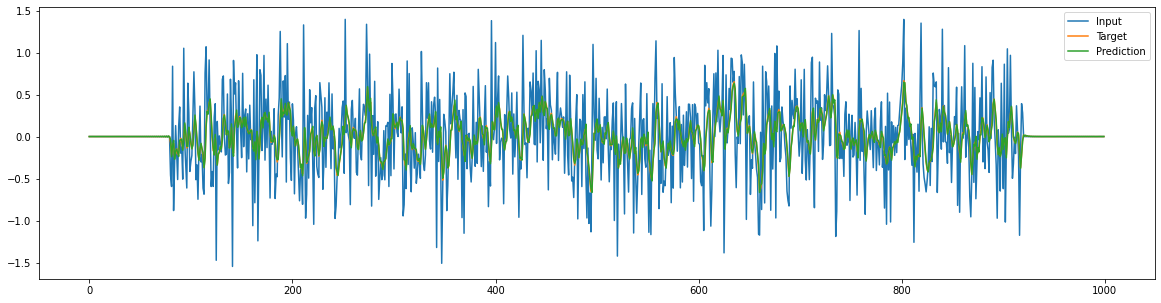

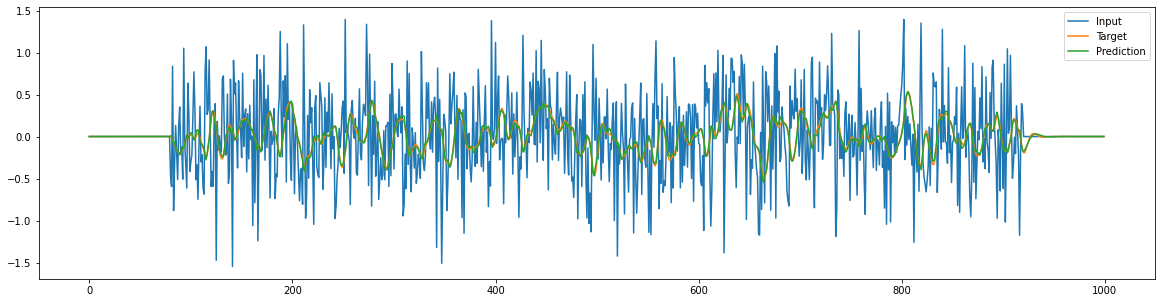

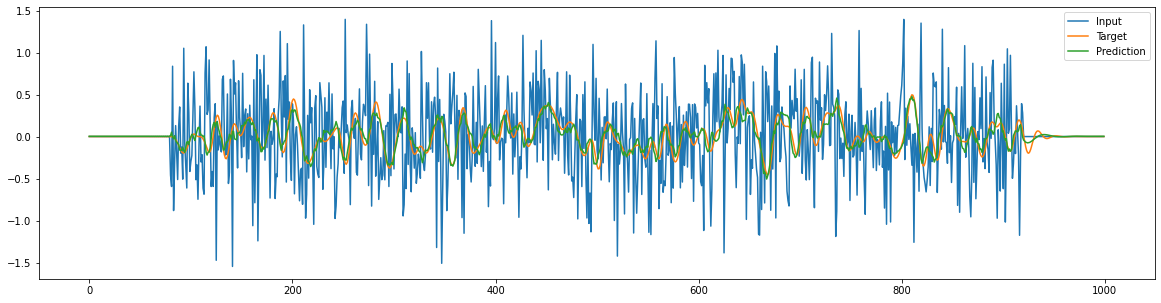

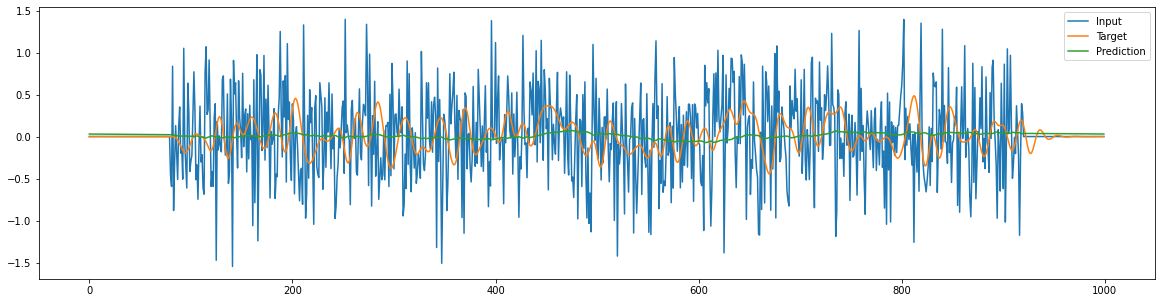

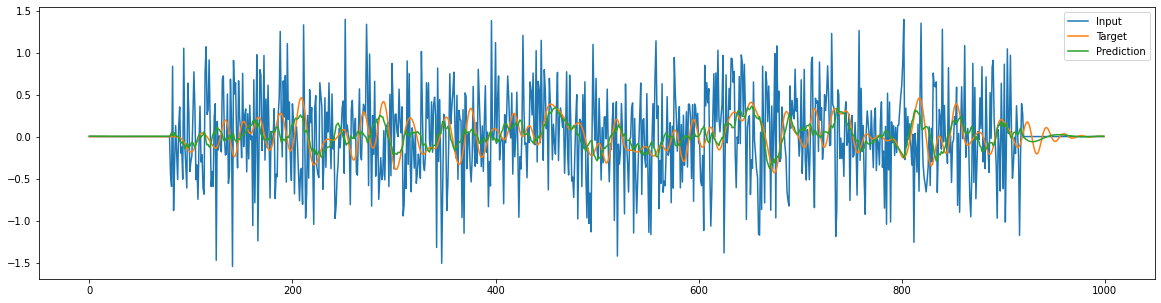

{'Aggregated Metrics': 0.21094378409909284,
 'Average inference time [seconds]': 1.0194778442382812e-06,
 'Normalized MSE': array([0.00110462, 0.00253746, 0.02225534, 0.11954555, 0.0644997 ]),
 'Normalized MSE Sum': 0.20994265930361625,
 'Training set size': 1000,
 'Training time [seconds]': 0.37914347648620605}
Best params :
[[-7.66040752e-01  1.08412600e+02  5.31983235e-01  6.95739274e+01
  -2.80845130e+04  8.79669544e-01 -1.33445383e-02]
 [ 3.39598972e-01  1.89443832e+01  4.83172121e-01  1.33102598e+02
   1.46897869e+03  7.06276558e-01  5.04870224e-01]
 [-3.39632070e-01 -1.96439464e+01  4.72356269e-01  1.33042380e+02
   1.59403113e+03  6.91774994e-01  4.95502871e-01]
 [ 6.42825901e-01 -9.62869350e+01  5.40471335e-01  6.66280323e+01
  -2.89102242e+04  8.88092624e-01  9.84839588e-01]
 [-6.45310478e-01  9.49073978e+01  5.38136990e-01  6.79867496e+01
  -2.79840943e+04  8.83215916e-01  9.59238842e-01]]


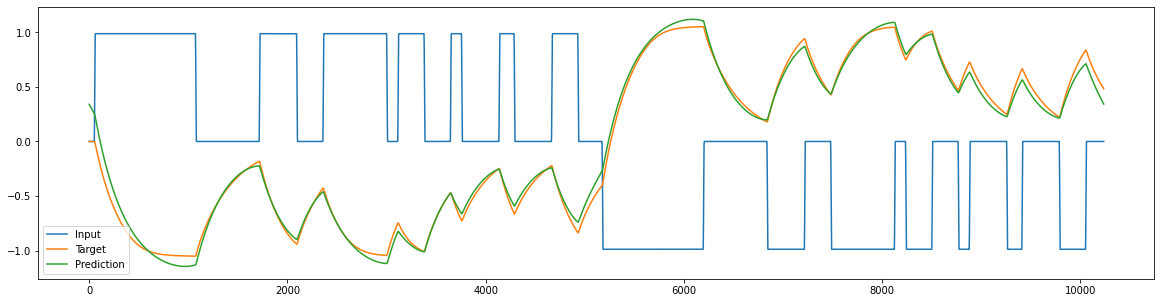

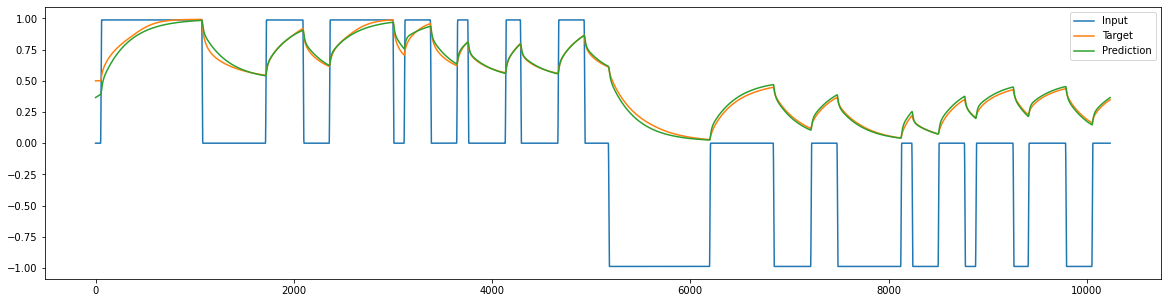

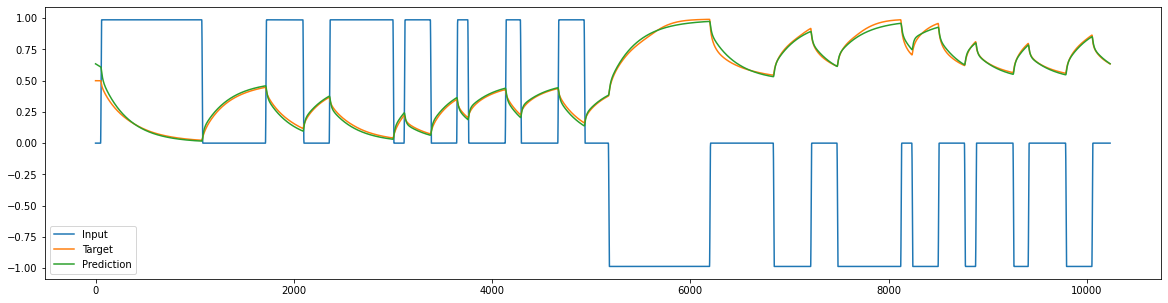

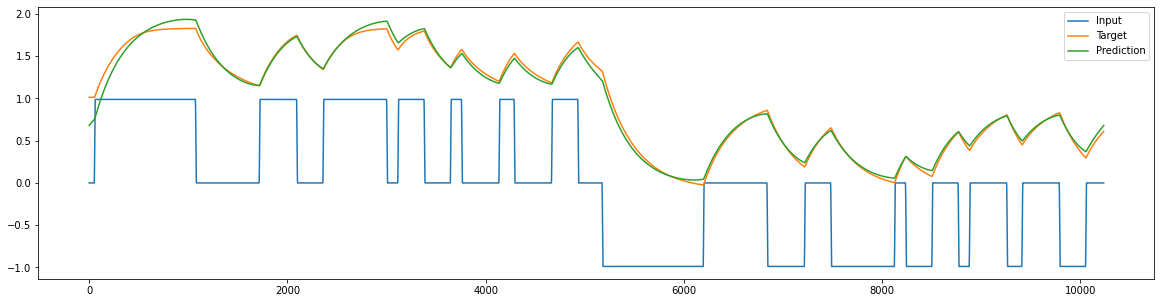

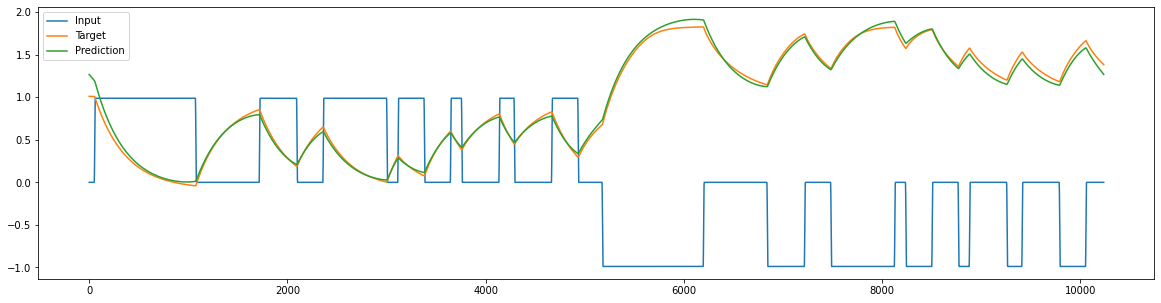

{'Aggregated Metrics': 0.01648973683780086,
 'Average inference time [seconds]': 1.3402543435016616e-06,
 'Normalized MSE': array([0.00356622, 0.00060994, 0.00043823, 0.00094256, 0.00069383]),
 'Normalized MSE Sum': 0.006250776011115547,
 'Training set size': 10236,
 'Training time [seconds]': 5.834060430526733}
Best params :
[[-1.14865448e+00 -1.67067847e+02  4.95110518e-01  1.43722814e+02
  -4.89690240e+00  5.28750452e-01  1.68966516e-01]
 [ 5.57676931e-01  1.06200160e+02  4.89477277e-01  1.70790514e+02
  -2.37809286e+00  5.12762869e-01  4.13199952e-01]
 [-5.76518310e-01 -1.34564541e+02  4.86692931e-01  2.17544716e+02
  -7.69449162e+00  5.16491476e-01  6.15574795e-01]
 [ 8.25277065e-01  1.27753355e+02  2.92762251e-01  8.91596191e+01
  -2.57526290e+00  3.42237204e-01  8.71128265e-01]
 [-3.96198166e-01 -8.82803445e+01  1.43173783e-01  6.68009757e+01
  -3.05367225e+00  5.07364238e-01  1.30953931e+00]]


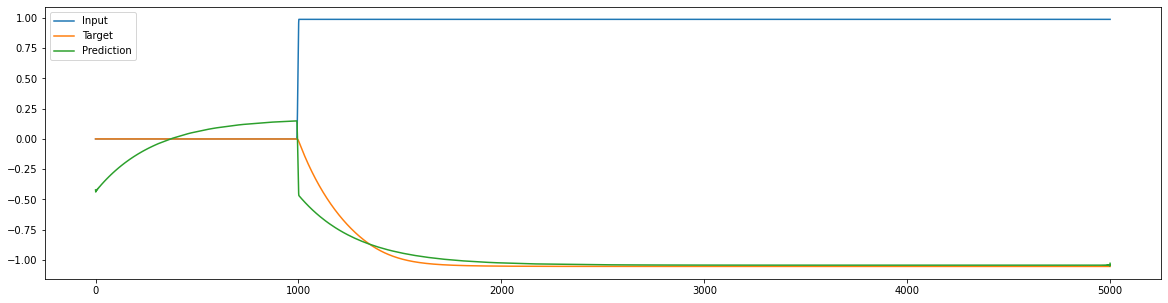

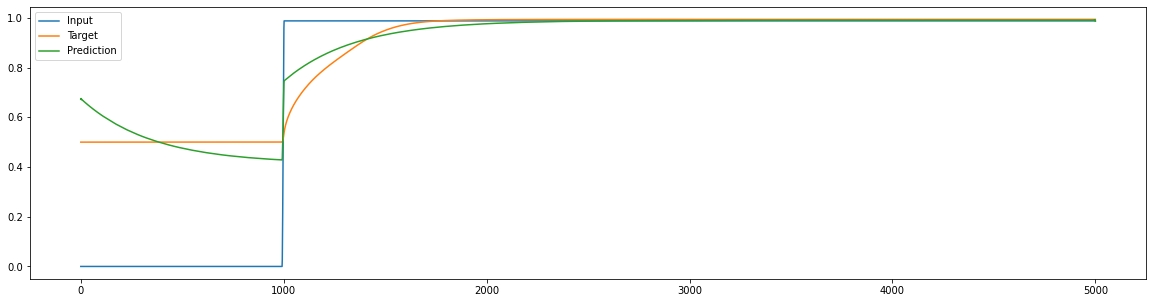

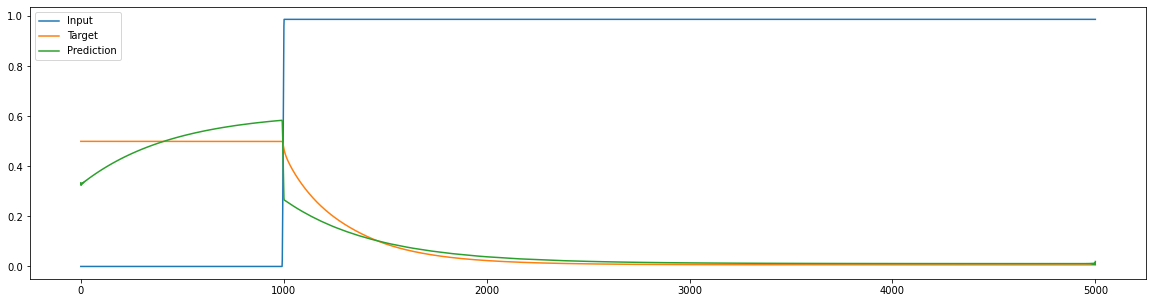

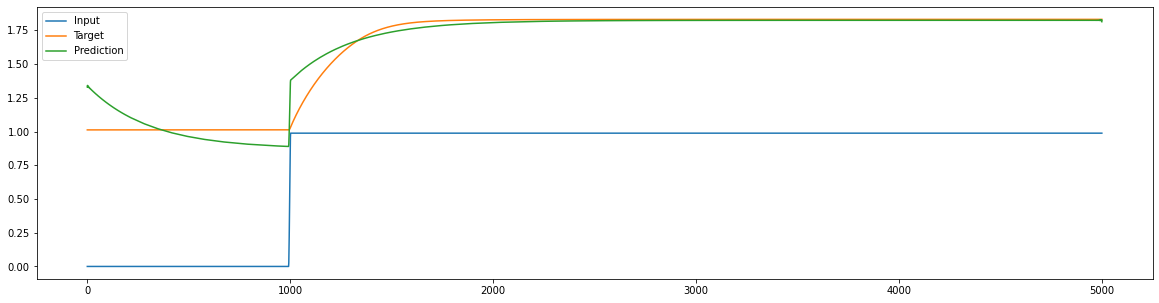

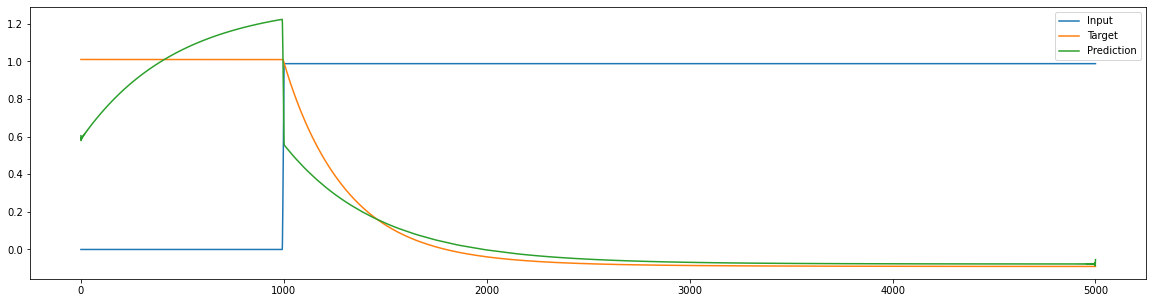

{'Aggregated Metrics': 0.032128708864990294,
 'Average inference time [seconds]': 1.3256759506253046e-06,
 'Normalized MSE': array([0.00760452, 0.00154883, 0.00659865, 0.00150124, 0.00987232]),
 'Normalized MSE Sum': 0.027125561138931817,
 'Training set size': 5001,
 'Training time [seconds]': 2.9593803882598877}
Best params :
[[-6.08811931e-01 -3.77015631e+01  3.97462379e-01  1.53987319e+02
   5.86836570e+03  8.55247897e-01  7.88535886e-03]
 [ 2.95188834e-01  2.52984551e+01  4.04804628e-01  1.40112574e+02
   1.84200474e+03  7.14654600e-01  5.02892086e-01]
 [-2.82319376e-01 -1.72515773e+01  4.24606808e-01  1.30292871e+02
   2.79430370e+03  7.22400136e-01  5.00507791e-01]
 [ 6.57925917e-01 -3.93274965e+02  1.72805651e+00 -6.50709016e+02
  -4.02021202e+05  3.13361371e+00  9.96242210e-01]
 [-4.97697186e-01 -2.07097635e+02  3.04372239e-01  2.51837983e+02
   4.03430878e+04  7.18659906e-01  9.85121637e-01]]


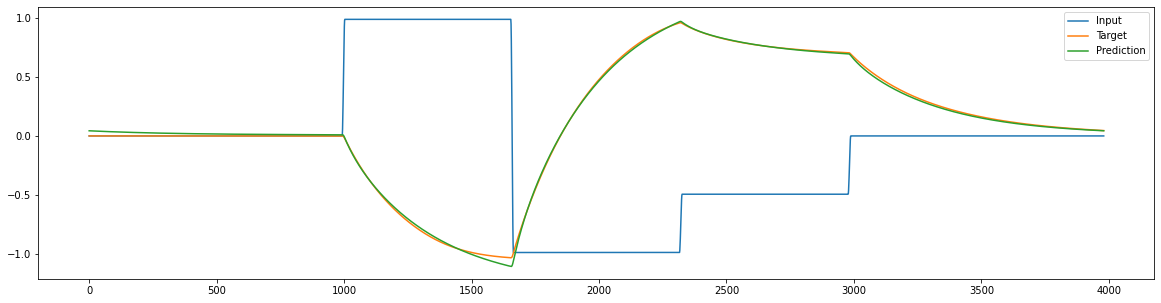

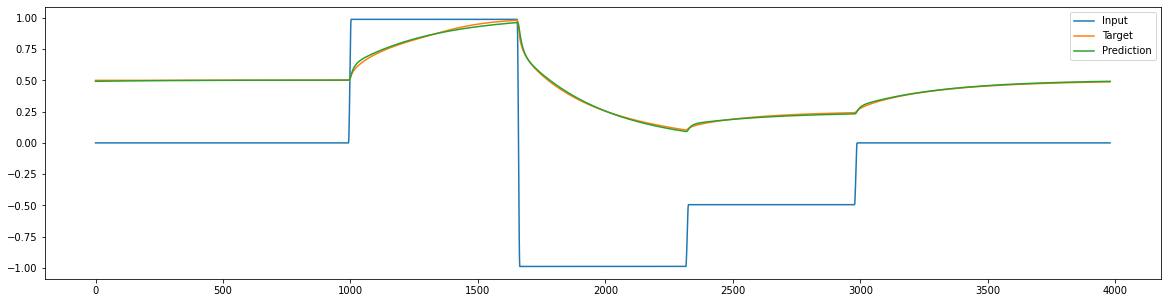

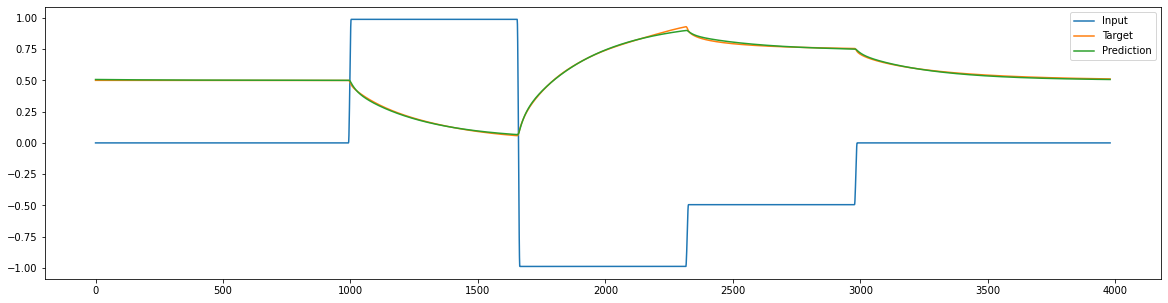

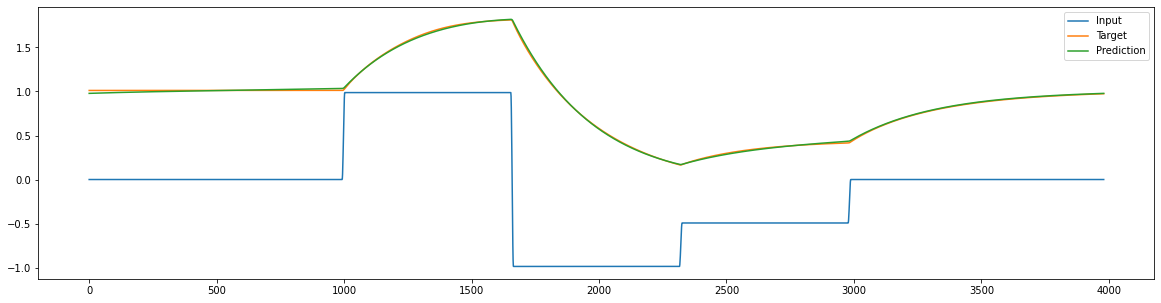

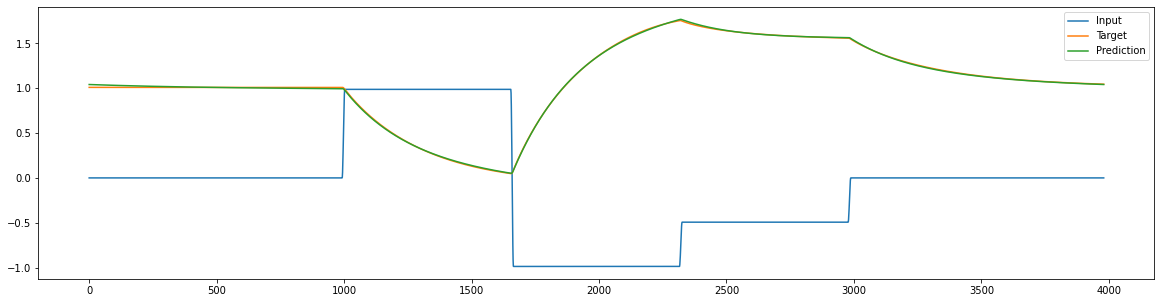

{'Aggregated Metrics': 0.004459180508590061,
 'Average inference time [seconds]': 1.5408871192424269e-06,
 'Normalized MSE': array([2.97191110e-04, 7.46426202e-05, 4.59572744e-05, 3.57980413e-05,
       2.18057817e-05]),
 'Normalized MSE Sum': 0.0004753948279365391,
 'Training set size': 3981,
 'Training time [seconds]': 4.481256723403931}
Best params :
[[-2.83483019e-01  3.27843825e+01  3.16952287e-01  5.64940697e+01
  -1.07983753e+04  1.42788025e+00 -1.24109249e-04]
 [ 3.90830293e+02  9.37915993e+03  1.29099113e+03  2.27424809e+05
   1.76402370e+06  1.13745166e+00  5.00166087e-01]
 [-3.94867576e+00 -1.39660494e+02  9.11930353e+00  2.29392885e+03
   2.66003445e+03  1.05142915e+00  4.99958152e-01]
 [ 2.31345275e-01 -2.57698883e+01  3.12657469e-01  5.68874825e+01
  -1.07784346e+04  1.42211592e+00  1.00958558e+00]
 [-2.28353695e-01  2.61945253e+01  3.17313846e-01  5.27296178e+01
  -1.02432919e+04  1.36390636e+00  1.00727186e+00]]


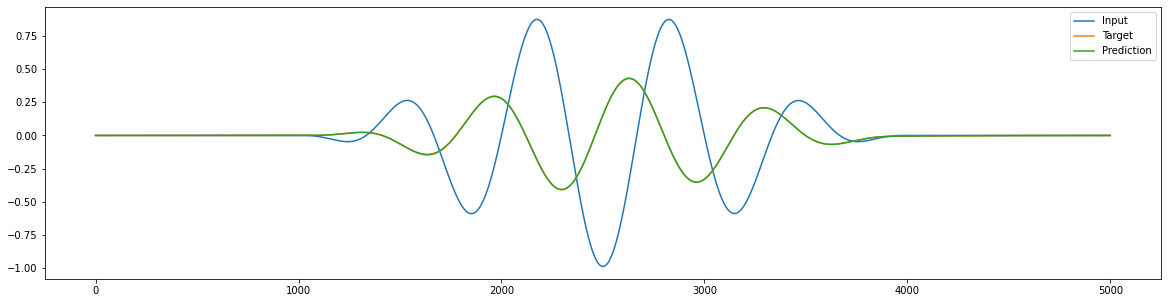

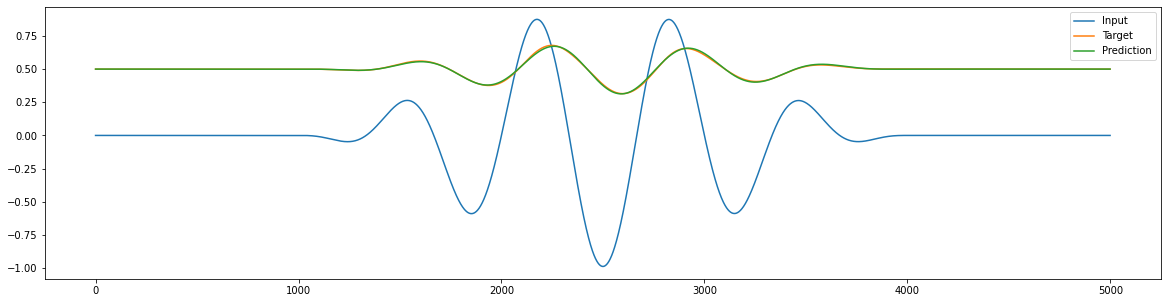

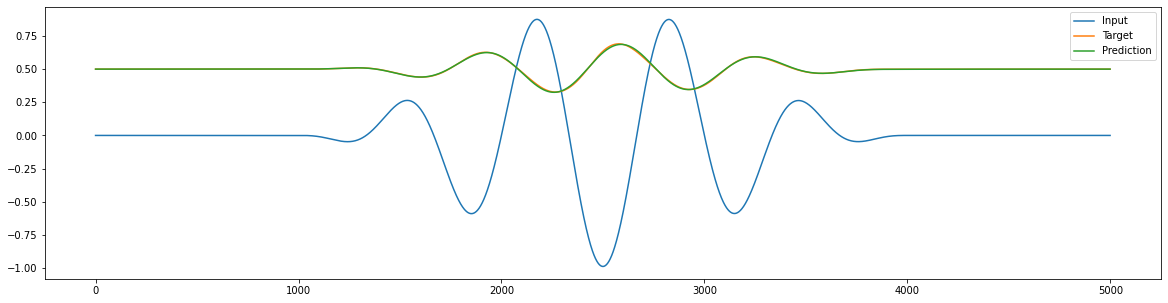

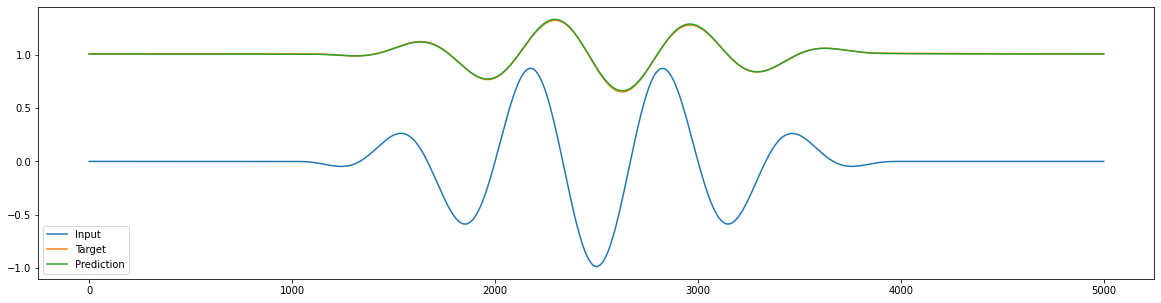

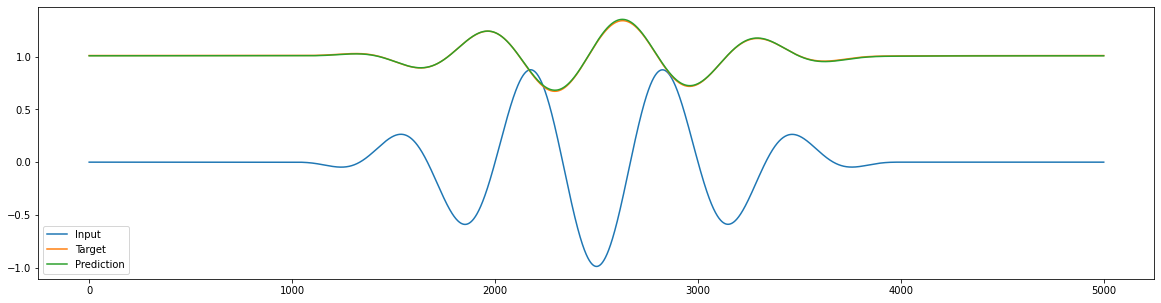

{'Aggregated Metrics': 0.00507446946194357,
 'Average inference time [seconds]': 3.654956817626953e-07,
 'Normalized MSE': array([5.73569699e-06, 2.94268167e-05, 2.02981403e-05, 9.26901130e-06,
       8.94081238e-06]),
 'Normalized MSE Sum': 7.367047764115515e-05,
 'Training set size': 5000,
 'Training time [seconds]': 1.5605590343475342}
Best params :
[[-4.00081911e-02  4.33795935e+00  2.43667119e-01  3.39900567e+01
  -6.29103722e+03  6.56897266e+00  5.27379795e-06]
 [ 6.81973074e-02 -1.87095906e+00  4.89175021e-01  5.14099049e+00
  -6.09022361e+02  1.10056124e+00  4.99999515e-01]
 [-6.81786611e-02  1.87278565e+00  4.89128845e-01  5.15383822e+00
  -6.10662322e+02  1.10216528e+00  5.00000157e-01]
 [ 3.81371880e-02 -3.44467150e+00  2.93790924e-01  2.93840610e+01
  -5.13043950e+03  5.45264857e+00  1.01079620e+00]
 [-3.80277467e-02  3.44608346e+00  3.10257119e-01  2.75010208e+01
  -4.79991785e+03  5.13664490e+00  1.00871106e+00]]


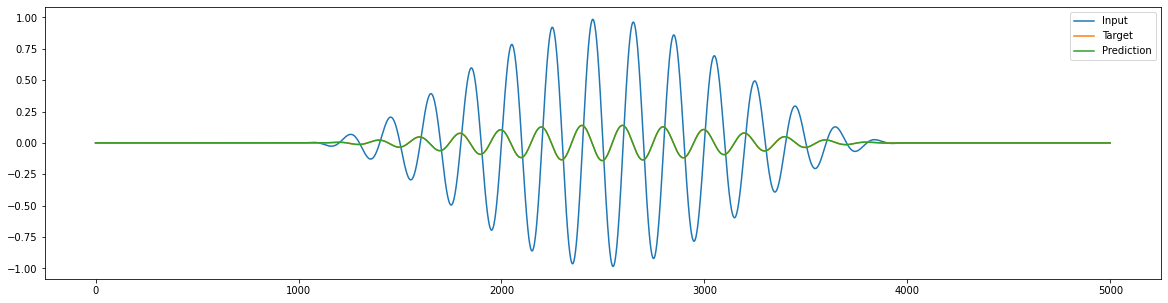

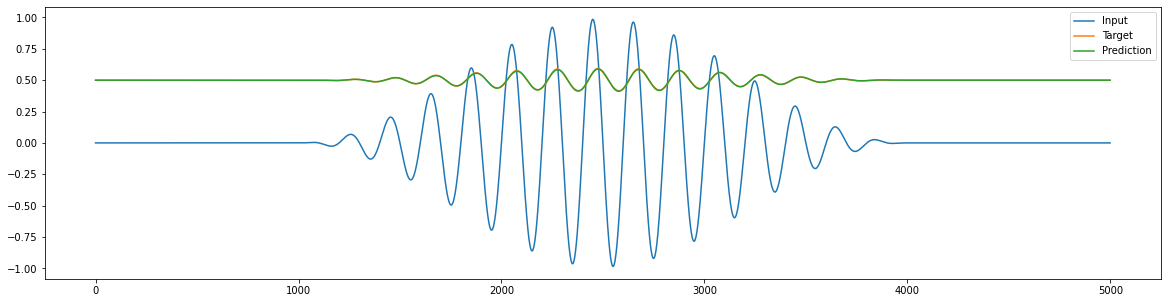

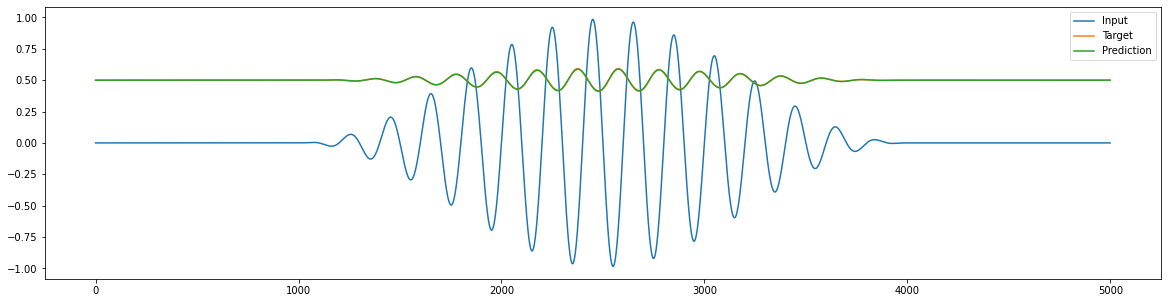

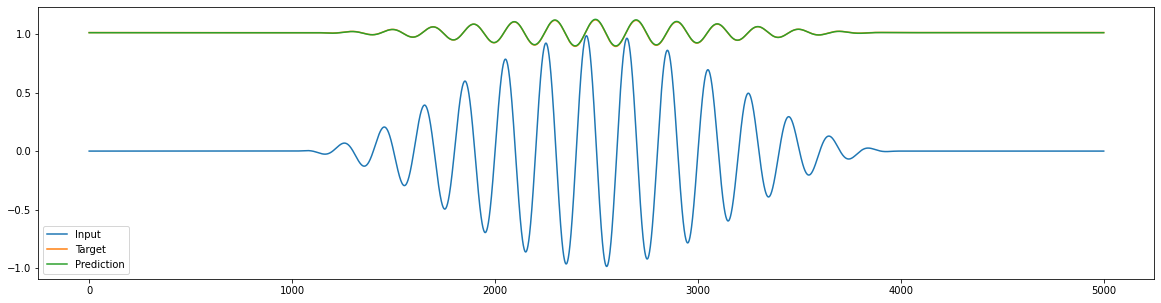

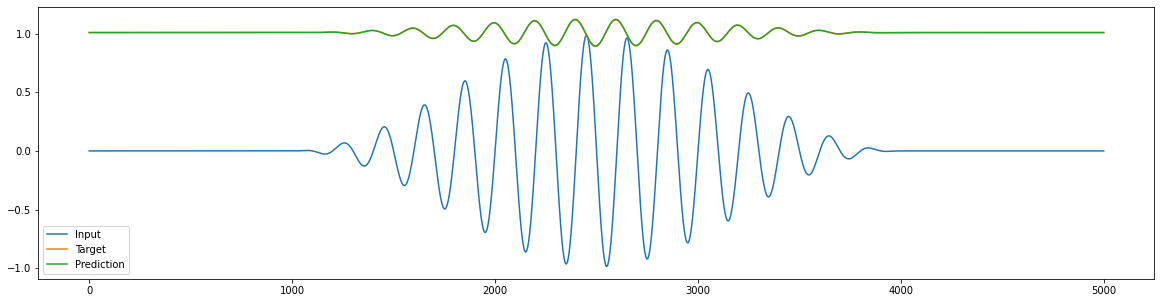

{'Aggregated Metrics': 0.005026152325539423,
 'Average inference time [seconds]': 3.215312957763672e-07,
 'Normalized MSE': array([1.48324345e-07, 1.04703718e-05, 1.04490833e-05, 2.24918772e-06,
       2.22964876e-06]),
 'Normalized MSE Sum': 2.5546615920430688e-05,
 'Training set size': 5000,
 'Training time [seconds]': 1.0230419635772705}
Best params :
[[-6.37447328e-03  2.76441509e-01  9.90908051e-02  8.69115220e+01
  -4.47590742e+03  7.20879059e+01  3.65168972e-07]
 [ 3.28865576e-02 -2.22234349e-01  4.99995184e-01  5.00501027e-01
   4.87230971e-01  5.00204910e-01  4.99999983e-01]
 [-3.28466439e-02  2.22190302e-01  4.99995185e-01  5.00501115e-01
   4.87221835e-01  5.00205056e-01  4.99999995e-01]
 [ 7.70347839e-03 -2.32291112e-01  4.99997478e-01  5.00514577e-01
   4.77368698e-01  5.00363317e-01  1.01156425e+00]
 [-7.70329849e-03  2.32311703e-01  4.99997342e-01  5.00516637e-01
   4.77357420e-01  5.00363393e-01  1.00947265e+00]]


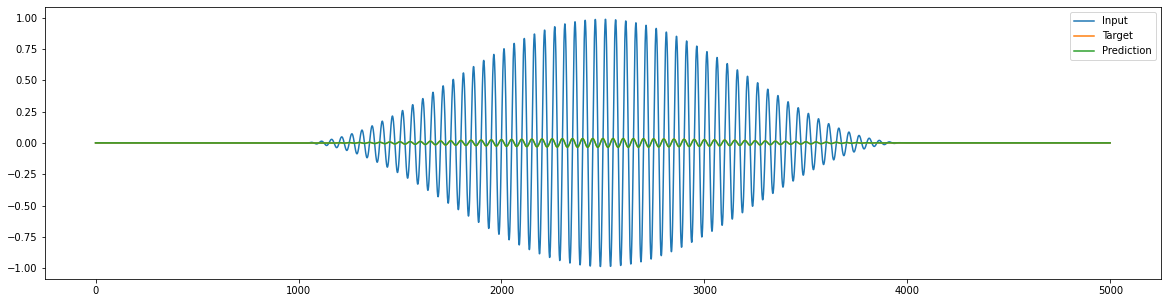

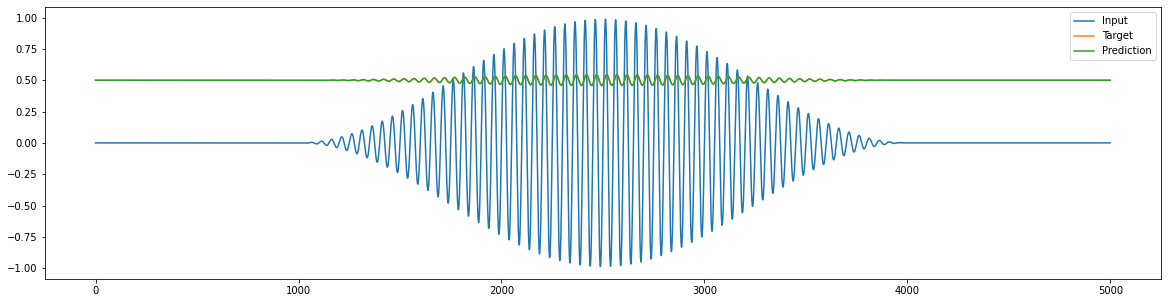

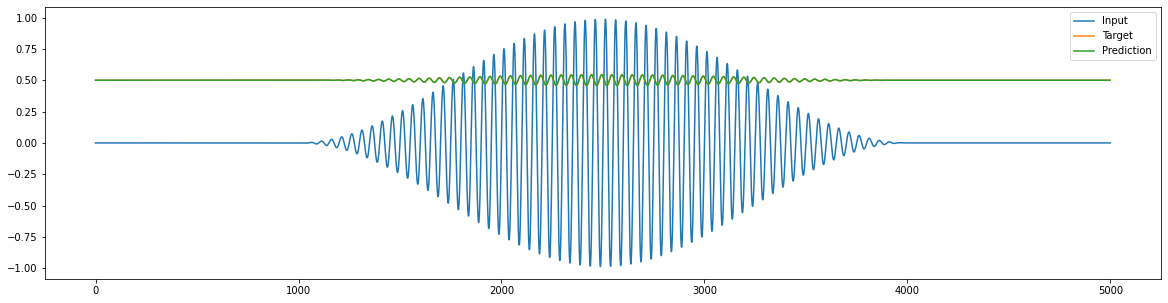

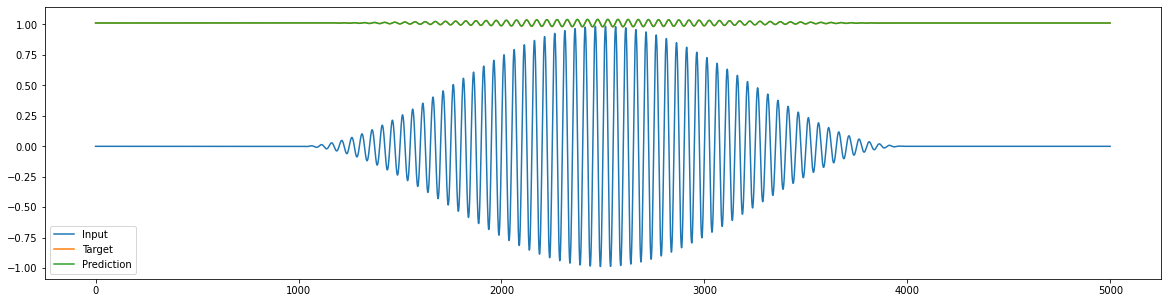

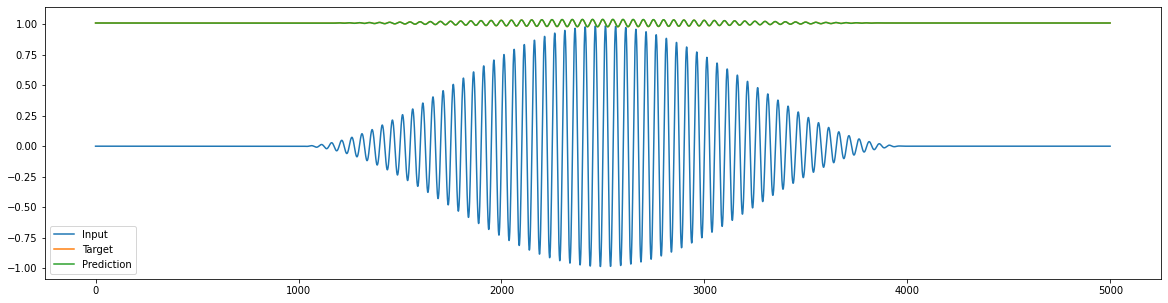

{'Aggregated Metrics': 0.005005227547078269,
 'Average inference time [seconds]': 3.6911964416503907e-07,
 'Normalized MSE': array([2.00925710e-07, 1.98666283e-06, 1.96950728e-06, 2.76961577e-07,
       2.76344423e-07]),
 'Normalized MSE Sum': 4.710401815444713e-06,
 'Training set size': 5000,
 'Training time [seconds]': 0.5328922271728516}
Best params :
[[ 2.80865904e-01 -4.04453766e+08  1.55282936e-03  3.21564504e+08
   1.04997399e+11  1.12615186e+00  5.00020756e-01]
 [ 7.93873420e-03  8.92958159e-02  1.70477064e-02  3.21715199e+00
   4.10446039e+00  8.96285862e-01  4.99807102e-01]
 [-7.87246523e-03 -9.26480886e-02  1.67500366e-02  3.18506701e+00
   4.38522753e+00  8.90513862e-01  5.00190134e-01]
 [-2.88482915e-01  4.55356658e+08  1.55282936e-03  4.56695910e+08
   1.47262797e+11  1.12432795e+00  4.99968329e-01]
 [-3.05619226e-01  2.50225421e+05  1.58647794e-03 -2.41838717e+05
  -7.80312484e+07  1.08242302e+00  5.04310958e-01]]


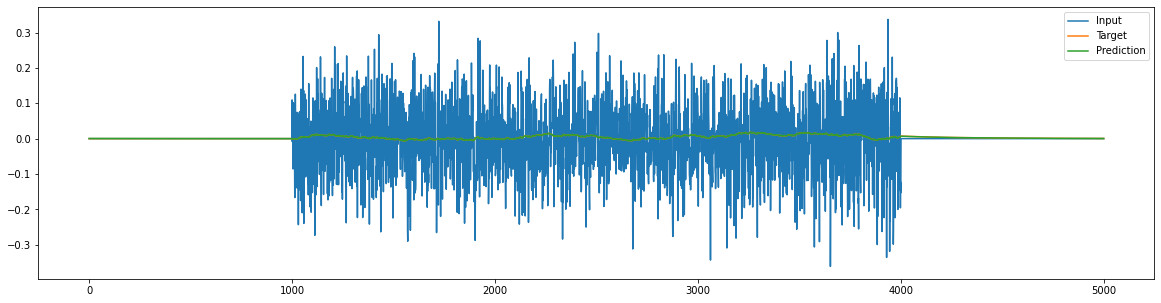

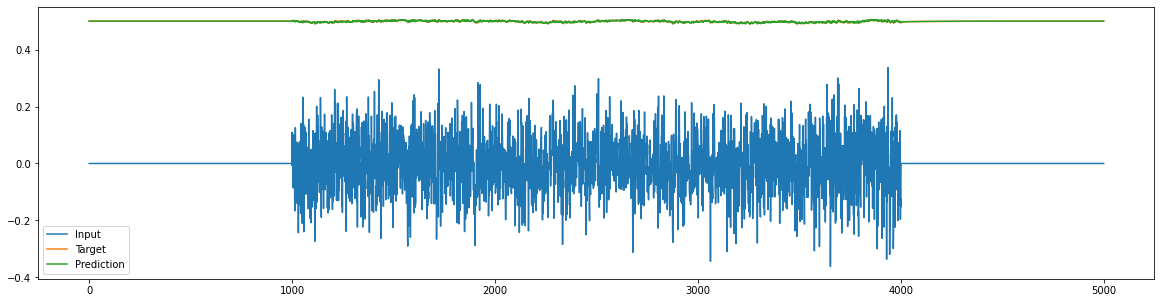

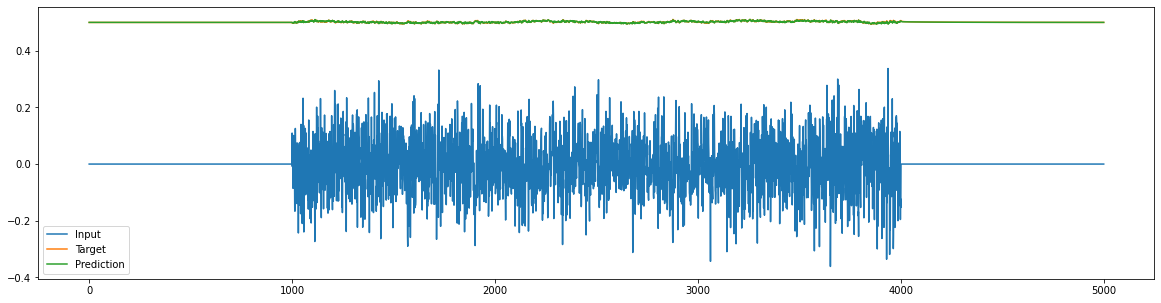

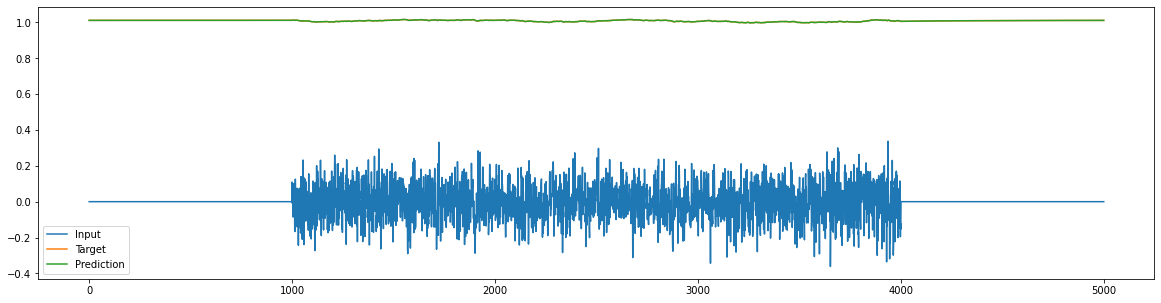

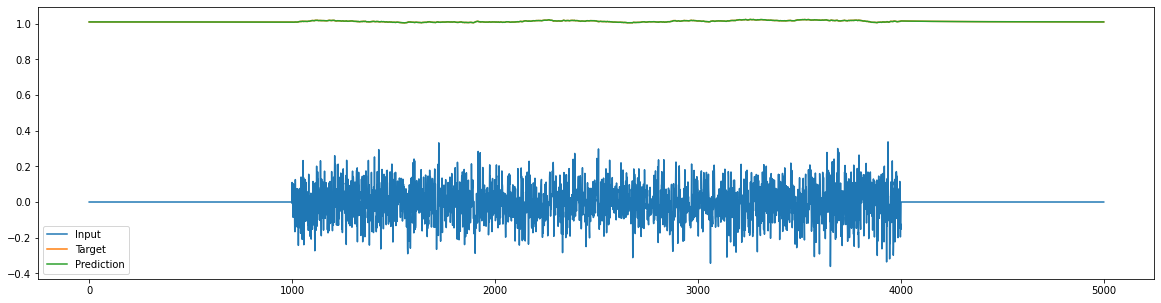

{'Aggregated Metrics': 0.0051390854012439684,
 'Average inference time [seconds]': 1.1958591558055576e-06,
 'Normalized MSE': array([1.32041767e-04, 1.98965688e-06, 1.97569901e-06, 6.39286744e-08,
       6.32339224e-08]),
 'Normalized MSE Sum': 0.00013613428527638508,
 'Training set size': 5001,
 'Training time [seconds]': 2.7189245223999023}


In [8]:
import pprint

pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_example/input1.csv', skip_plot=False, example_dataset=True))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_example/input2.csv', skip_plot=False, example_dataset=True))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_example/input3.csv', skip_plot=False, example_dataset=True))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_example/input4.csv', skip_plot=False, example_dataset=True))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_example/input5.csv', skip_plot=False, example_dataset=True))

pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_phase1/input0.csv', skip_plot=False))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_phase1/input1.csv', skip_plot=False))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_phase1/input2.csv', skip_plot=False))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_phase1/input3.csv', skip_plot=False))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_phase1/input4.csv', skip_plot=False))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_phase1/input5.csv', skip_plot=False))
pprint.pprint(compute_metrics('/content/drive/MyDrive/Colab Notebooks (1)/AI4IA/DataSet_phase1/input6.csv', skip_plot=False))